Here I'm going to explore the notification moduel and how they work. First, I need to understand their fields

In [52]:
import pandas as pd
from pandas.io.json import json_normalize
%matplotlib inline
from datetime import datetime, timedelta

# LOAD DOS DADOS

In [2]:
df = pd.read_json("../../data/raw_data/base_22012019.json")

In [3]:
grades_df = pd.read_excel("../../data/raw_data/nota_provas.xls")

Estas são as datas onde as avaliação dos alunos que compõe a base ocorreram.

In [55]:
date_v1 = datetime(day=10, year=2018, month=12)
date_v2 = datetime(day=11, month=2, year=2019)
date_v3 = datetime(day=18, month=3, year=2019)

# EXPLORAÇÃO inicial

In [4]:
notifications_df = df[df["model"] == "notifications.notification"]

In [56]:
notifications_df.shape

(13219, 3)

In [6]:
notifications_df["fields"].head(10)[34636]

{'meta': None,
 'task': 1,
 'user': 8,
 'level': 3,
 'viewed': False,
 'creation_date': '2018-10-28'}

Uma notificação possui os seguintes campos no log:
1. meta: 
2. user: que coleta o id do user para qual a notificação foi enviada
3. Level: O nível da notificação está relacionado à tarefa que ela notifica sobre, este campo possui 4 valores mas somente 3 significados
    
    3.1 1,2: Significam que a tarefa está em dia 
    
    3.2 3: Significa que a tarefa está atrasada
    
    3.3 4: Significa que o prazo para realizar a tarefa já acabou
4. viewed: que possui valor de verdadeiro ou falso indicando se a notifcação foi vista ou não pelo usuário
5. creation_date: A data de criação daquela notificação
6. task: id da task que aquela notificação está associada

# Limpeza dos dados

é preciso extrair as colunas existentes dentro da coluna "fields", para isso, eu vou utilizar a função json_normalize, nativa do pandas.

In [7]:
def extract_flatten_dataframe(df, column, meta_list):
    df_fields = json_normalize(data=df[column], meta=meta_list)
    df_fields.index = df.index
    return df_fields.join(df, how="outer")

In [8]:
notification_fields = json_normalize(data=notifications_df["fields"], meta=["meta", "task", "user", "level", "viewed", "creation_date"] )
notification_fields.index = notifications_df.index
notification_fields = notification_fields.astype({"level": pd.CategoricalDtype()})
notification_fields["creation_date"] = pd.to_datetime(notification_fields["creation_date"])
notification_df_flatted = notification_fields.join(notifications_df, how="outer")

In [9]:
notification_df_flatted.dtypes

creation_date    datetime64[ns]
level                  category
meta                     object
task                      int64
user                      int64
viewed                     bool
fields                   object
model                    object
pk                       object
dtype: object

In [10]:
notification_df_flatted.sample(10)

,creation_date,level,meta,task,user,viewed,fields,model,pk
44082,2019-01-13,4,None,8,56,False,"{'meta': None, 'task': 8, 'user': 56, 'level':...",notifications.notification,9729
39651,2018-11-26,4,None,8,22,False,"{'meta': None, 'task': 8, 'user': 22, 'level':...",notifications.notification,5108
36718,2018-11-16,3,None,36,11,False,"{'meta': None, 'task': 36, 'user': 11, 'level'...",notifications.notification,2085
37342,2018-11-19,3,None,12,56,False,"{'meta': None, 'task': 12, 'user': 56, 'level'...",notifications.notification,2729
46319,2019-01-19,1,None,20,45,False,"{'meta': None, 'task': 20, 'user': 45, 'level'...",notifications.notification,11966
42621,2018-12-10,3,None,1,7,False,"{'meta': None, 'task': 1, 'user': 7, 'level': ...",notifications.notification,8218
39328,2018-11-25,1,None,37,28,False,"{'meta': None, 'task': 37, 'user': 28, 'level'...",notifications.notification,4775
44508,2019-01-15,3,None,42,27,False,"{'meta': None, 'task': 42, 'user': 27, 'level'...",notifications.notification,10155
47064,2019-01-21,3,None,42,16,False,"{'meta': None, 'task': 42, 'user': 16, 'level'...",notifications.notification,12711
35318,2018-11-08,1,None,10,18,False,"{'meta': None, 'task': 10, 'user': 18, 'level'...",notifications.notification,685


In [11]:
notification_fields.dtypes

creation_date    datetime64[ns]
level                  category
meta                     object
task                      int64
user                      int64
viewed                     bool
dtype: object

Como dá pra ver o pandas não consegue inferir muito bem os data types das colunas, vou utilizar meu conhecimento sobre elas para colocar valores mais baratos e que correspondem melhor aos seus valores.m

# Resources

In [12]:
resources_df = df[df["model"] == "topics.resource"]

In [13]:
df[df["model"] == "topics.resource"]["fields"][120546]

{'_my_subclass': 'webpage',
 'name': 'Avaliação Diagnóstica',
 'slug': 'avaliacao-diagnostica',
 'brief_description': '<div>\r\n  <small>Valor: 0,25 ponto (<font color="#ff0000"><i>extra</i></font>)</small>\r\n</div>\r\n<div>\r\n  <small>Início: 05/11/2018</small>&nbsp;<small style="margin-left: 10px">Final: 11/11/2018</small>\r\n</div>',
 'show_window': False,
 'all_students': True,
 'visible': True,
 'order': 1,
 'topic': 5,
 'create_date': '2018-10-23T03:36:54.806Z',
 'last_update': '2018-11-05T12:08:57.125Z',
 'students': [],
 'groups': [],
 'tags': [62, 63]}

In [14]:
resource_meta_list = ["_my_subclass", "visible", "students", "groups", "tags", "all_students", "order", "topic", 
             "show_window", "brief_description", "slug", "name"]

In [15]:
resources_flatten_df = extract_flatten_dataframe(resources_df, "fields", resource_meta_list).drop("fields", axis=1)
resources_flatten_df.head(5)

,_my_subclass,all_students,brief_description,create_date,groups,last_update,name,order,show_window,slug,students,tags,topic,visible,model,pk
120546,webpage,True,"<div>\r\n <small>Valor: 0,25 ponto (<font col...",2018-10-23T03:36:54.806Z,[],2018-11-05T12:08:57.125Z,Avaliação Diagnóstica,1,False,avaliacao-diagnostica,[],"[62, 63]",5,True,topics.resource,9
120547,pdffile,True,,2018-10-23T19:05:01.720Z,[],2018-12-17T15:06:52.038Z,"Prova anterior (prova 01, 2007.2, turma E6)",37,True,prova-anterior-prova-01-20072-turma-e6,[],"[10, 11, 12, 13, 14, 15, 16, 17]",6,True,topics.resource,10
120548,pdffile,True,,2018-10-23T19:06:18.936Z,[],2018-12-17T15:06:52.052Z,"Prova anterior (prova 01, 2008.1, turma 52)",38,True,prova-anterior-prova-01-20081-turma-52,[],"[10, 11, 12, 13, 14, 15, 16, 17]",6,True,topics.resource,11
120549,pdffile,True,,2018-10-23T19:07:09.839Z,[],2018-12-17T15:06:52.063Z,"Prova anterior (prova 01, 2008.2, turma A5)",39,True,prova-anterior-prova-01-20082-turma-a5,[],"[10, 11, 12, 13, 14, 15, 16, 17]",6,True,topics.resource,12
120550,pdffile,True,,2018-10-23T19:07:53.570Z,[],2018-12-17T15:06:52.078Z,"Prova anterior (prova 01, 2009.2, turma A5)",40,True,prova-anterior-prova-01-20092-turma-a5,[],"[10, 11, 12, 13, 14, 15, 16, 17]",6,True,topics.resource,13


# Pendências

In [16]:
df[df["model"] == "pendencies.pendencies"]["fields"][120708]

{'action': 'view',
 'begin_date': '2018-10-28T02:53:00Z',
 'end_date': '2018-10-28T02:55:00Z',
 'limit_date': None,
 'resource': 163}

In [17]:
pendencies_meta_list = ["action", "begin_date", "end_date", "limit_date", "resource"]

In [152]:
pendencies_df = extract_flatten_dataframe(df[df["model"] == "pendencies.pendencies"], "fields", pendencies_meta_list)

In [153]:
pendencies_df.dtypes

action        object
begin_date    object
end_date      object
limit_date    object
resource       int64
fields        object
model         object
pk            object
dtype: object

In [154]:
pendencies_df.head(2)

,action,begin_date,end_date,limit_date,resource,fields,model,pk
120708,view,2018-10-28T02:53:00Z,2018-10-28T02:55:00Z,None,163,"{'action': 'view', 'begin_date': '2018-10-28T0...",pendencies.pendencies,1
120709,view,2018-10-28T02:54:00Z,2018-10-31T02:54:00Z,None,164,"{'action': 'view', 'begin_date': '2018-10-28T0...",pendencies.pendencies,2


In [175]:
# change pendencies data type to make easier to manipulate data and analyze as well
date_columns = ["begin_date", "end_date", "limit_date"]
for column in date_columns:
    #pendencies_df[column] = pendencies_df[column].apply(lambda date: pd.Timestamp(date, tz=None))
    pendencies_df[column] = pd.to_datetime(pendencies_df[column])
    pendencies_df[column] = pendencies_df[column].apply(lambda timestamp: timestamp.replace(tzinfo=None))


#pendencies_df[date_columns] = pd.to_datetime(pendencies_df[date_columns])
#pendencies_df[date_columns] = pd.Timestamp(pendencies_df[date_columns])

In [176]:
pendencies_df["action"] = pendencies_df["action"].astype("category")

In [181]:
pendencies_df.dtypes

action              category
begin_date    datetime64[ns]
end_date      datetime64[ns]
limit_date    datetime64[ns]
resource               int64
fields                object
model                 object
pk                    object
dtype: object

In [182]:
pendencies_df.head(2)

,action,begin_date,end_date,limit_date,resource,fields,model,pk
120708,view,2018-10-28 02:53:00,2018-10-28 02:55:00,NaT,163,"{'action': 'view', 'begin_date': '2018-10-28T0...",pendencies.pendencies,1
120709,view,2018-10-28 02:54:00,2018-10-31 02:54:00,NaT,164,"{'action': 'view', 'begin_date': '2018-10-28T0...",pendencies.pendencies,2


# Users Data
Como os usuários são o principal objeto de pesquisa deste relatório, eu preciso coletar os IDs deles para juntar as notificações e "dar à um responsável".

In [183]:
users_df = df[df["model"] == "users.user"]
users_df

,fields,model,pk
34528,{'password': 'pbkdf2_sha256$30000$5DROf4Pf3BPR...,users.user,1
34529,{'password': 'pbkdf2_sha256$30000$u3Lg5la328P5...,users.user,2
34530,{'password': 'pbkdf2_sha256$30000$Tg55KDswGl6t...,users.user,3
34531,{'password': 'pbkdf2_sha256$30000$sN16VkfYDIiS...,users.user,4
34532,{'password': 'pbkdf2_sha256$30000$x85db28ZviCz...,users.user,6
34533,{'password': 'pbkdf2_sha256$30000$YuhP7bGSlXwn...,users.user,7
34534,{'password': 'pbkdf2_sha256$30000$l7WAB2nBwfTg...,users.user,8
34535,{'password': 'pbkdf2_sha256$30000$DOj6RbuvrpDK...,users.user,9
34536,{'password': 'pbkdf2_sha256$30000$wbwdFEajjHed...,users.user,10
34537,{'password': 'pbkdf2_sha256$30000$DOPLvJQYYOz4...,users.user,11


In [184]:
users_df["fields"][34528]

{'password': 'pbkdf2_sha256$30000$5DROf4Pf3BPR$tPd1JbDlLqrUzoY/JcUSfparBrp7n0ERZKWgpfnbG/Y=',
 'last_login': '2019-01-22T12:36:36.447Z',
 'is_superuser': True,
 'email': 'admin@amadeus.br',
 'username': 'Administrador',
 'last_name': 'Geral',
 'social_name': None,
 'description': '',
 'image': '',
 'date_created': '2018-10-19T16:55:27.084Z',
 'last_update': '2018-11-04T03:31:13.036Z',
 'show_email': 1,
 'is_staff': True,
 'is_active': True,
 'groups': [],
 'user_permissions': []}

# Dicionário dos dados
1. Password: Senha criptografada
2. Last_Login: a última vez que o usuário logou no sistema
3. is_superuser: Significa que o usuário é um super usuário, tem privilégios ou admin.
4. email: e-mail pertecente ao usuário 
5. username: nome que o usuário quer que outros usuários o vejam
6. last_name: Sobrenome do usuário
7. social_name: Nome social que o usuário quer escolher para ser demonstrado 
8. description: ?
9. image: Caminho para a imagem do usuário
10. date_created: Data em que o usuário foi criado
11. last_update: a última vez que os dados do usuário foram modificados
12. show_email: Uma booleana que informa se o e-mail é visiível para outros usuários
13. is_staff: se ele é do tipo admin
14. is_active: Se o usuário está ativo, caso sim, ele pode entrar no sistema, senão, é impossível
15. groups: Grupos de permissão ao qual esse usuário pertence ("professor", "estudante"...)
16. user_permissions = permissões individuais que ele possui ("criar tópico" , "deletar tópico", "editar tópico")

In [185]:
# fields:  
user_fields = ["password", "last_login", "is_superuser", "email", "username", "last_name", "social_name", "description", 
               "imagem", "date_created", "last_update", "show_email", "is_staff", "is_active", "groups", "user_permissions"]

In [186]:
user_df_flatten = extract_flatten_dataframe(users_df, column="fields",meta_list=user_fields).astype({"pk": "int64"})

In [187]:
user_df_flatten.dtypes

date_created        object
description         object
email               object
groups              object
image               object
is_active             bool
is_staff              bool
is_superuser          bool
last_login          object
last_name           object
last_update         object
password            object
show_email           int64
social_name         object
user_permissions    object
username            object
fields              object
model               object
pk                   int64
dtype: object

# Notas dos alunos

In [188]:
grades_df.dtypes

id_estudante      int64
v1              float64
v2              float64
dtype: object

In [189]:
grades_df.head(10)

,id_estudante,v1,v2
0,11,0.0,0.00
1,12,4.0,7.00
2,13,6.5,7.50
3,14,6.5,10.00
4,15,6.0,8.50
5,16,6.0,3.50
6,17,0.5,4.00
7,18,1.5,7.25
8,19,7.5,8.50
9,20,2.0,9.75


# Vou remover as seguintes colunas:
1. Groups, pois não possui nenhum valor diferente de vazio (ou nulo).

In [190]:
user_df_flatten["groups"].value_counts()

[]    106
Name: groups, dtype: int64

In [191]:
user_df_flatten_clean = user_df_flatten.drop(["groups", "fields", "password"], axis=1)

# Junção entre os datasets
Para otimizar, irei coletar somente o username dos usuários durante o join com as notificações, depois eu irei buscar mais informações sobre eles.m

In [192]:
notifications_with_user_grades_df = pd.merge(notification_df_flatted, grades_df, left_on=["user"], right_on=["id_estudante"])

In [193]:
notifications_with_user_grades_df.head(10)

,creation_date,level,meta,task,user,viewed,fields,model,pk,id_estudante,v1,v2
0,2018-11-05,1,None,9,11,False,"{'meta': None, 'task': 9, 'user': 11, 'level':...",notifications.notification,105,11,0.0,0.0
1,2018-11-06,1,None,9,11,False,"{'meta': None, 'task': 9, 'user': 11, 'level':...",notifications.notification,195,11,0.0,0.0
2,2018-11-06,1,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,261,11,0.0,0.0
3,2018-11-06,1,None,7,11,False,"{'meta': None, 'task': 7, 'user': 11, 'level':...",notifications.notification,338,11,0.0,0.0
4,2018-11-07,1,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,463,11,0.0,0.0
5,2018-11-07,1,None,8,11,False,"{'meta': None, 'task': 8, 'user': 11, 'level':...",notifications.notification,574,11,0.0,0.0
6,2018-11-08,1,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,682,11,0.0,0.0
7,2018-11-08,1,None,11,11,False,"{'meta': None, 'task': 11, 'user': 11, 'level'...",notifications.notification,756,11,0.0,0.0
8,2018-11-08,1,None,8,11,False,"{'meta': None, 'task': 8, 'user': 11, 'level':...",notifications.notification,844,11,0.0,0.0
9,2018-11-09,3,None,10,11,False,"{'meta': None, 'task': 10, 'user': 11, 'level'...",notifications.notification,927,11,0.0,0.0


# Análise
Primeiro eu vou explorar um pouco sobre a distribuição na quantiadde de notificações por usuário.

In [194]:
students_not_count_series = notifications_with_user_grades_df.groupby("user").size()

Com o grupo  de usuários que mais recebeu notificação e o grupo de usuários que menos recebeu notificações, eu vou tentar analisar qual a diferença disso e o rendimento comparado entre eles, irei colocar o 25% de cada. 

Existe um "lixo" nos dados que são os estudantes criados pelos adm, geralmente seu nomes são compostos por "Estudante X"

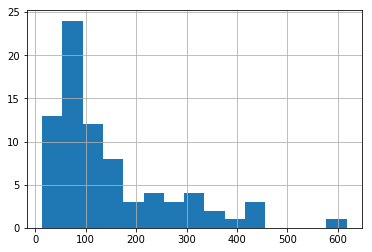

In [195]:
students_not_count_series.sort_values(ascending=False).hist(bins=15)

In [196]:
students_not_count_series.quantile([.1,.25, .5, .75, .9])

0.10     38.00
0.25     62.50
0.50    104.00
0.75    197.25
0.90    321.10
dtype: float64

Como da pra ver a distância é bem grande entre o 1ª quartil (.25) e o menores 10% assim como a distância é ainda mais grotesca com entre o 3ª quartil e o top 10%, quase o dobro de notificações recebidas.

## distribuição por nível de pendência
Os níveis de pendência variam entre 4 valores, sendo que o valor 1 e 2 representam o mesmo dado,
1. O valor 1 e 2 representam tarefas que ainda estão no prazo
2. O valor 3 representa tarefas que estão atrasadas
3. O valor 4 representa tarefas que não podem mais ser completadas/perdidas

In [197]:
notifications_with_user_grades_df.loc[notifications_with_user_grades_df["user"] == 14, ["v1", "v2"]].head(1)

,v1,v2
532,6.5,10.0


In [198]:
count_notification_level_by_user = notifications_with_user_grades_df.groupby(["user", "level"]).size()

In [199]:
count_notification_level_by_user.reset_index().pivot(index="user", columns="level", values=0).head(5)

level,1,2,3,4
user,,,,
11,71.0,NaN,179.0,95.0
12,45.0,NaN,2.0,NaN
13,58.0,NaN,39.0,43.0
14,23.0,NaN,7.0,43.0
15,64.0,NaN,76.0,43.0


# Indexando as notificações por tempo, análise temporal

In [200]:
notifications_with_user_grades_df.columns

Index(['creation_date', 'level', 'meta', 'task', 'user', 'viewed', 'fields',
       'model', 'pk', 'id_estudante', 'v1', 'v2'],
      dtype='object')

In [201]:
notifications_with_user_grades_df.index = notifications_with_user_grades_df["creation_date"]

In [202]:
notifications_with_user_grades_df.index

DatetimeIndex(['2018-11-05', '2018-11-06', '2018-11-06', '2018-11-06',
               '2018-11-07', '2018-11-07', '2018-11-08', '2018-11-08',
               '2018-11-08', '2018-11-09',
               ...
               '2019-01-04', '2019-01-13', '2019-01-14', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22'],
              dtype='datetime64[ns]', name='creation_date', length=11404, freq=None)

In [203]:
notifications_with_user_grades_df.resample('M').agg({"v1": "mean", "v2": "mean"})

,v1,v2
creation_date,,
2018-11-30,4.025120,4.690423
2018-12-31,3.089561,3.603879
2019-01-31,4.214038,4.814518


Dado muito bom: a média de notificações visualizadas e quantidade de notificações visualizadas por semana de cada usuário

In [204]:
notifications_with_user_grades_df.groupby(["user", pd.Grouper(freq="W")])\
.agg({"viewed": ["mean", "sum"]}).reset_index().head(2)

user creation_date viewed     
                       mean  sum
0   11    2018-11-11    0.0  0.0
1   11    2018-11-18    0.0  0.0

In [205]:
notifications_with_user_grades_df.groupby(["user", pd.Grouper(freq="M")])\
.agg({"viewed": ["mean", "sum"]}).reset_index().head(2)

user creation_date    viewed     
                          mean  sum
0   11    2018-11-30  0.058824  9.0
1   11    2018-12-31  0.073770  9.0

# Associar recurso à pendência

In [206]:
pendencies_df.columns

Index(['action', 'begin_date', 'end_date', 'limit_date', 'resource', 'fields',
       'model', 'pk'],
      dtype='object')

In [207]:
resources_flatten_df.columns

Index(['_my_subclass', 'all_students', 'brief_description', 'create_date',
       'groups', 'last_update', 'name', 'order', 'show_window', 'slug',
       'students', 'tags', 'topic', 'visible', 'model', 'pk'],
      dtype='object')

In [208]:
notifications_with_user_grades_df.columns

Index(['creation_date', 'level', 'meta', 'task', 'user', 'viewed', 'fields',
       'model', 'pk', 'id_estudante', 'v1', 'v2'],
      dtype='object')

In [209]:
pendencies_with_resources = pd.merge(pendencies_df, resources_flatten_df, left_on=["resource"], right_on=["pk"])

In [210]:
pendencies_with_resources.columns

Index(['action', 'begin_date', 'end_date', 'limit_date', 'resource', 'fields',
       'model_x', 'pk_x', '_my_subclass', 'all_students', 'brief_description',
       'create_date', 'groups', 'last_update', 'name', 'order', 'show_window',
       'slug', 'students', 'tags', 'topic', 'visible', 'model_y', 'pk_y'],
      dtype='object')

In [211]:
notications_with_resources_pendencies = pd.merge(notifications_with_user_grades_df, pendencies_with_resources, left_on=["task"], right_on=["pk_x"])

In [212]:
notications_with_resources_pendencies.shape

(11404, 36)

In [213]:
notications_with_resources_pendencies.dtypes

creation_date        datetime64[ns]
level                      category
meta                         object
task                         object
user                          int64
viewed                         bool
fields_x                     object
model                        object
pk                           object
id_estudante                  int64
v1                          float64
v2                          float64
action                     category
begin_date           datetime64[ns]
end_date             datetime64[ns]
limit_date           datetime64[ns]
resource                     object
fields_y                     object
model_x                      object
pk_x                         object
_my_subclass                 object
all_students                   bool
brief_description            object
create_date                  object
groups                       object
last_update                  object
name                         object
order                       

# Influência da notificação na V1

Para isto, só vou coletar notificações com pendências onde a data limite foi antes da data da v1

In [228]:
v1_notifications = notications_with_resources_pendencies[notications_with_resources_pendencies["end_date"] <= date_v1]\
.drop(columns=["v2"])

In [229]:
v1_notifications.shape

(8408, 35)

Segundo a informação abaixo, pelo menos 75% possuem no mínimo 30 notificaçoes de pendências, e 50% possuem 71 notificações de pendências ou mais

In [225]:
v1_notifications.groupby("user").size().quantile([.1,.25, .5, .75, .9])

0.10     18.00
0.25     30.25
0.50     71.00
0.75    139.25
0.90    266.60
dtype: float64